## Computing Convergence ($\kappa$) from lens mass distribution

In [1]:
# %%
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.Profiles.interpol import Interpol


#import emcee for MCMC
import emcee

#import corner module with relevant installations for implementation
import corner

### Computing Lensing Potential from Lenstronomy's in-built funtion in LensModel

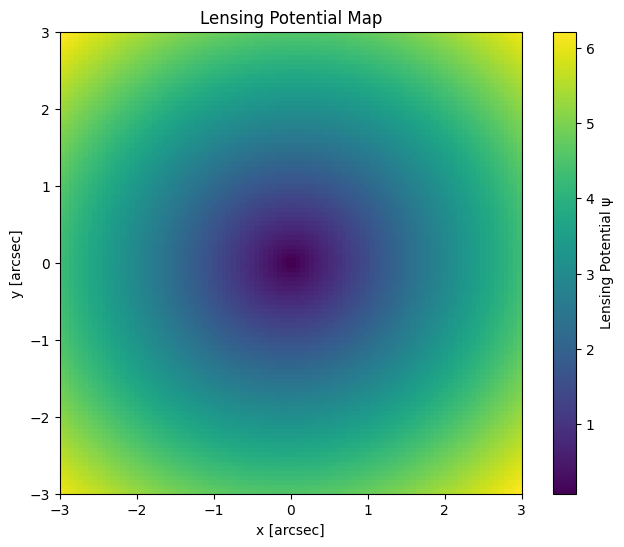

In [2]:
#1. Define lens model and parameters
lens_model_list = ['EPL', 
                   #'SHEAR'
                   ]
lens_model = LensModel(lens_model_list=lens_model_list)
lens_params = [
    {'theta_E': 1.45, 'gamma':2.05, 'e1': 0.1, 'e2': 0.05, 'center_x': 0.0, 'center_y': 0.0},  # EPL params
    #{'gamma1': 0.02, 'gamma2': 0.01}  # Shear params
]

# 2. Create grid
x_grid, y_grid = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

# 3. Compute convergence using LensModel
kappa_map_lenstronomy = lens_model.kappa(x_grid, y_grid, lens_params)

# 4. Compute potential map using LensModel
potential_map_lenstronomy = lens_model.potential(x_grid, y_grid, lens_params)

# 5. Plotting the potential map
plt.figure(figsize=(8, 6))
plt.imshow(potential_map_lenstronomy, extent=(-3, 3, -3, 3),
              origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Lensing Potential ψ')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.title('Lensing Potential Map')
plt.show()


### Computing Lensing Potential from my own custom function that takes in as arguments: convergnce ($\kappa$) and pixel size
this is required so that I can take the **convergence** computed from the projected mass distribution of an IllutrisTNG galaxy (which doesn't have any well-defined lens model describing it), and then compute the lensing potential for use in the INTERPOL class

the "*kappa_to_potential*" function numerically implements the following analytic method for computing the 2D lensing potential: 
$$\begin{split}
2\kappa(\boldsymbol{\theta})&=\nabla^2_{\boldsymbol{\theta}}\psi (\boldsymbol{\theta}) \\
\tilde{\kappa}(\boldsymbol{k}) &= \text{FT}\left[ \frac{1}{2} \nabla^2_{\boldsymbol{\theta}} \psi \right] \\
&= \frac{1}{2} \nabla ^2_{\boldsymbol{\theta}} \int \psi e^{-i\boldsymbol{k}\cdot\boldsymbol{\theta}} d \boldsymbol{\theta} \\
&= \frac{1}{2} (-i\boldsymbol{k})^2 \tilde{\psi}(\boldsymbol{k}) \\
\Rightarrow \psi(\boldsymbol{\boldsymbol{\theta}}) &= - \frac{1}{(2\pi)^2} \int \frac{2\tilde{\kappa}(\boldsymbol{k})}{\boldsymbol{k}^2} e^{i\boldsymbol{k} \cdot\boldsymbol{\theta}} d\boldsymbol{k} \\
&= \text{FT}^{-1} \left[ -\frac{2}{\boldsymbol{k}^2} \tilde{\kappa}(\boldsymbol{k}) \right]
\end{split}$$

where $\boldsymbol{\theta} = (x,y)$ and $\boldsymbol{k} = (k_x, k_y)$ in the 2D projected plane

In [3]:
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq

def kappa_to_potential(kappa_map, pixel_size_arcsec):
    """
    Convert a convergence (κ) map to lensing potential (ψ) using Fourier transforms.
    
    Parameters:
    - kappa_map: 2D numpy array of convergence values.
    - pixel_size_arcsec: pixel scale in arcseconds.

    Returns:
    - potential_map: 2D numpy array of lensing potential ψ.
    """
    n = kappa_map.shape[0]
    L = n * pixel_size_arcsec  # total angular size
    dk = 1.0 / L

    kx = fftfreq(n, d=pixel_size_arcsec)
    ky = fftfreq(n, d=pixel_size_arcsec)
    kx, ky = np.meshgrid(kx, ky)

    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # avoid divide by zero at DC

    kappa_ft = fft2(kappa_map)
    psi_ft = -2 * kappa_ft / (4 * np.pi**2 * k2)  # Note 4π² from FFT convention
    #psi_ft[0, 0] = 0.0  # subtract mean, zero potential at DC mode
    #psi_ft[0, 0] = 6.0  # zero potential at DC mode

    potential_map = np.real(ifft2(psi_ft))
    return potential_map


In [4]:
# Convert kappa map to lensing potential using the custom function
# I am using the kappa map that I computed using Lenstronomy's EPL model and built-in function
# kappa_map_lenstronomy is the 2D convergence map from Lenstronomy's EPL+SHEAR model

Delta_pix = 0.06 # pixel size in arcseconds
numPix = kappa_map_lenstronomy.shape[0]
lensing_potential_custom = kappa_to_potential(kappa_map_lenstronomy, Delta_pix)


x_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)
y_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)

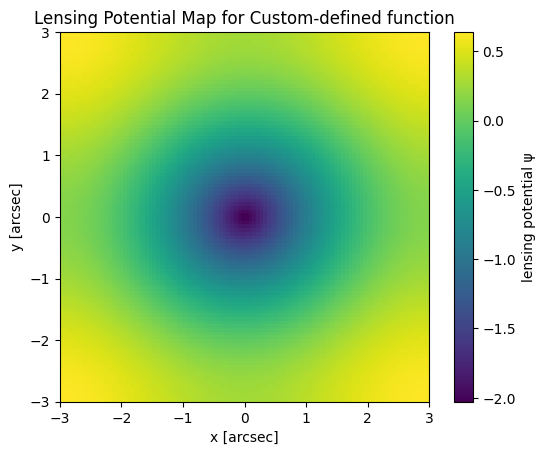

In [5]:
plt.imshow((lensing_potential_custom), origin='lower', cmap='viridis', extent=[-3, 3, -3, 3])
plt.colorbar(label='lensing potential ψ')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.title('Lensing Potential Map for Custom-defined function')
plt.show()

#### Here I compute the difference in Lensing potential values for the 2 methods and display the results/summary plots and statistics

Mean absolute difference: 3.4537516480425023
Max absolute difference: 5.575819423292528


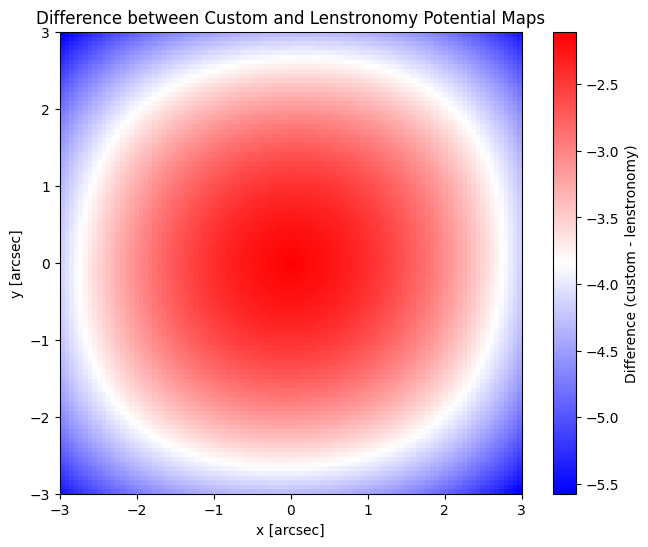

In [6]:
# Compare the two potential maps
diff = lensing_potential_custom - potential_map_lenstronomy

print("Mean absolute difference:", np.mean(np.abs(diff)))
print("Max absolute difference:", np.max(np.abs(diff)))

plt.figure(figsize=(8, 6))
plt.imshow(diff, origin='lower', cmap='bwr', extent=[-3, 3, -3, 3])
plt.colorbar(label='Difference (custom - lenstronomy)')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.title('Difference between Custom and Lenstronomy Potential Maps')
plt.show()

### Computing the Deflection angles (which are physical) using my custom-defined function and the built-in function in Lenstronomy
The results of the two methods are compared and some summary plots and statistics provided
Comment: The deflection angles do not agree 🙁

In [7]:
# Compute deflection angles using Lenstronomy's EPL model using built-in function
alpha_x_lenstronomy, alpha_y_lenstronomy = lens_model.alpha(x_grid, y_grid, lens_params)


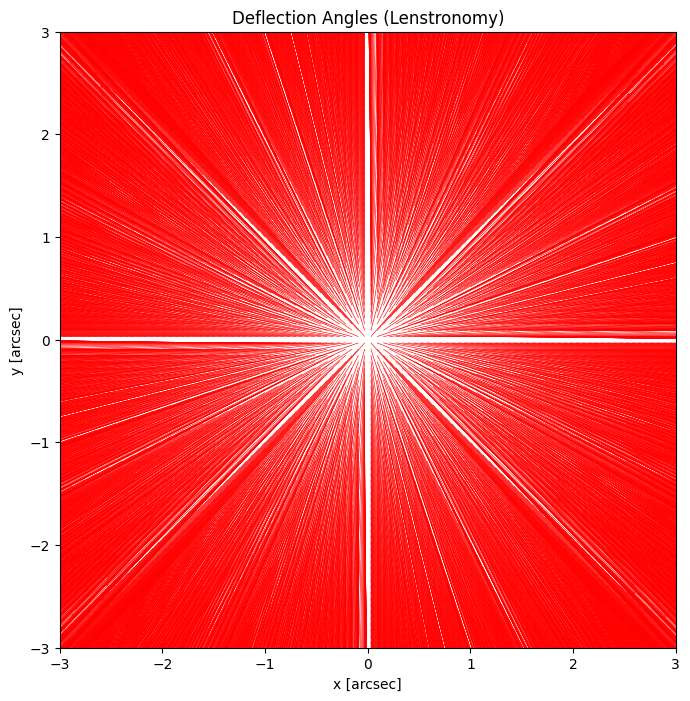

In [8]:
# Plot deflection angles as a vector field (quiver plot) for the Lenstronomy built-in function
plt.figure(figsize=(8, 8))
plt.quiver(x_grid, y_grid, alpha_x_lenstronomy, alpha_y_lenstronomy, 
           color='red', angles='xy', scale_units='xy', scale=0.5, width=0.001)
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.title('Deflection Angles (Lenstronomy)')
plt.xlim(x_grid.min(), x_grid.max())
plt.ylim(y_grid.min(), y_grid.max())
plt.gca().set_aspect('equal')
plt.show()

In [9]:
# Here, I define a custom function to compute deflection angles from the lensing potential by calculating the gradient of the potential map.
def potential_to_deflection(potential, delta_pix):
    """
    Compute deflection angles (α_x, α_y) from lensing potential.
    """
    alpha_y, alpha_x = np.gradient(potential, delta_pix)  # dψ/dx, dψ/dy
    return alpha_x, alpha_y

#%%

alpha_x_custom, alpha_y_custom = potential_to_deflection(lensing_potential_custom, Delta_pix)


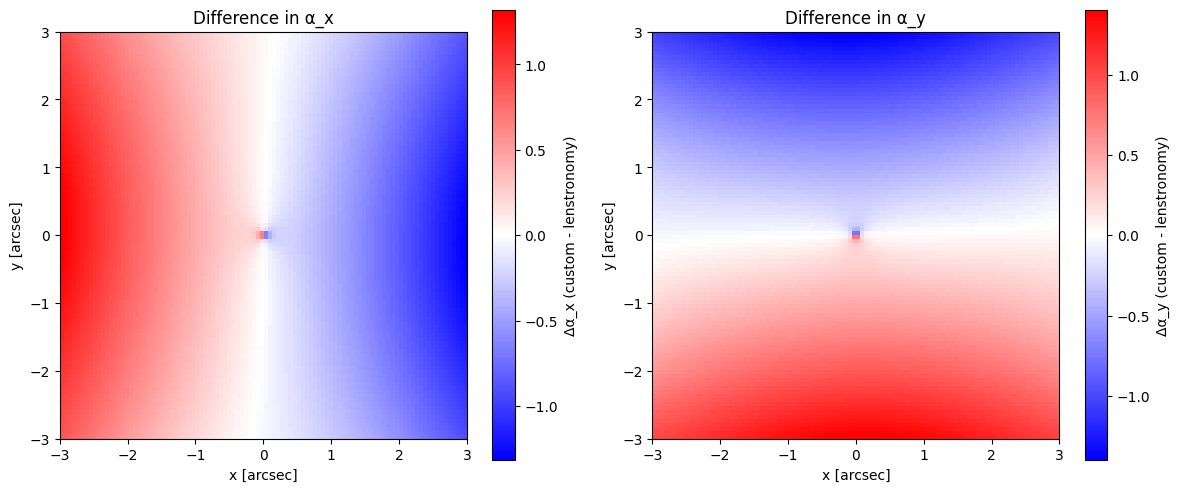

In [10]:
# compare the two  different deflection angle maps

diff_alpha_x = alpha_x_custom - alpha_x_lenstronomy
diff_alpha_y = alpha_y_custom - alpha_y_lenstronomy

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(diff_alpha_x, origin='lower', cmap='bwr', extent=[-3, 3, -3, 3])
plt.colorbar(label='Δα_x (custom - lenstronomy)')
plt.title('Difference in α_x')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')

plt.subplot(1, 2, 2)
plt.imshow(diff_alpha_y, origin='lower', cmap='bwr', extent=[-3, 3, -3, 3])
plt.colorbar(label='Δα_y (custom - lenstronomy)')
plt.title('Difference in α_y')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')

plt.tight_layout()
plt.show()

In [11]:
print("Mean absolute difference in alpha_x:", np.mean(np.abs(diff_alpha_x)))
print("Max absolute difference in alpha_x:", np.max(np.abs(diff_alpha_x)))
print("Mean absolute difference in alpha_y:", np.mean(np.abs(diff_alpha_y)))
print("Max absolute difference in alpha_y:", np.max(np.abs(diff_alpha_y)))

Mean absolute difference in alpha_x: 0.5579888501063588
Max absolute difference in alpha_x: 1.3172183999327522
Mean absolute difference in alpha_y: 0.6083012355416483
Max absolute difference in alpha_y: 1.4010924125448345


In [12]:
print(np.max(alpha_x_custom), np.max(alpha_x_lenstronomy))
print(np.min(alpha_y_custom), np.min(alpha_y_lenstronomy))

1.2893038671837795 1.5318393844790008
-1.3837553479164952 -1.6374325100225602


In [13]:
#data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 5000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = Delta_pix  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)

/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_55317/151800252.py:94: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


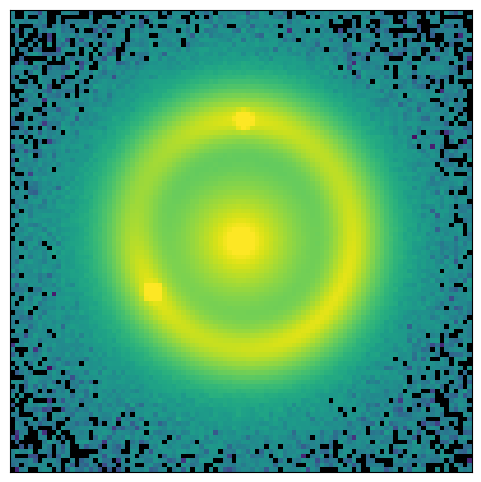

In [14]:


# %% Set up the Input Model

z_lens = 0.35  # lens redshift
z_source = 1.0  # source redshift
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)  # cosmology for angular diameter distance calculations

# lensing quantities

lens_model_list = ['INTERPOL']
kwargs_lens = [{ 'grid_interp_x': x_angular,
    'grid_interp_y': y_angular,
    'f_' : potential_map_lenstronomy,
    'f_x': alpha_x_lenstronomy,
    'f_y': alpha_y_lenstronomy
}]


lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)




# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x =0.05
source_y = 0.1



# list of light profiles (for lens and source)
# 'SERSIC': Sersic profile of source

phi_G, q = 0.5, 0.8
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
#phi_G, q = 0.9, 0.9
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Lensed Image positions

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=Delta_pix, search_window=numPix * Delta_pix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'viridis'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()